In [16]:
# Import required libraries
import os
import cv2
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow/Keras imports for deep learning
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Scikit-learn imports for data splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
# Custom preprocessing module for palm images
DATASET_PATH = "dataset"
from img_preprocessing import PalmPreprocessor

# ========== DATA LOADING AND PREPROCESSING ==========
# Initialize lists to store images and corresponding labels
images, labels = [], []
# Get sorted list of class names (person names) from dataset directory
class_names = sorted(os.listdir(DATASET_PATH))

# Iterate through each class (person) in the dataset
for idx, cls in enumerate(class_names):
    cls_path = os.path.join(DATASET_PATH, cls)  # Path to current class folder

    # Process each image in the current class folder
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)  # Full path to image
        
        # Use custom preprocessor to preprocess the palm image
        processed = PalmPreprocessor().preprocess_v2(img_path)

        # Skip if preprocessing fails
        if processed is None:
            import time
            time.sleep(5)  # Wait before trying next image
            continue

        # Add processed image and label to lists
        images.append(processed)
        labels.append(idx)  # Use index as numerical label

# Convert lists to numpy arrays for model training
images = np.array(images)
# Convert labels to one-hot encoded format (e.g., [0,0,1,0] for class 2)
labels = to_categorical(labels, num_classes=len(class_names))

In [18]:
# ========== DATA SPLITTING ==========
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, shuffle=True
)

In [19]:
# Define image size (model expects 128x128 grayscale images)
IMG_SIZE = 128


# ========== CNN MODEL ARCHITECTURE ==========
# Create Sequential model (linear stack of layers)
model = Sequential([
    # First convolutional layer: 32 filters, 3x3 kernel, ReLU activation
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    # Max pooling to reduce spatial dimensions by half
    MaxPooling2D(2,2),

    # Second convolutional layer: 64 filters
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Third convolutional layer: 128 filters
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Flatten 3D feature maps to 1D vector for dense layers
    Flatten(),
    # Fully connected layer with 128 neurons
    Dense(128, activation='relu'),
    # Dropout layer to prevent overfitting (50% neurons randomly disabled)
    Dropout(0.5),
    # Output layer with softmax activation for multi-class classification
    Dense(len(class_names), activation='softmax')
])

c:\Users\ASUS\OneDrive\Desktop\palm-recognition-csy2082\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Low learning rate for stable training
    loss='categorical_crossentropy',       # Standard loss for multi-class classification
    metrics=['accuracy']                   # Track accuracy during training
)

In [21]:
# Display model architecture summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,580 (12.61 MB)

 Trainable params: 3,304,580 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# ========== MODEL TRAINING ==========
# Train the model for 20 epochs with 16 samples per batch
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_split=0.2  # Use 20% of training data for validation
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.2965 - loss: 1.3609 - val_accuracy: 0.3000 - val_loss: 1.3150
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.3317 - loss: 1.2916 - val_accuracy: 0.7200 - val_loss: 1.2130
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.5327 - loss: 1.2150 - val_accuracy: 0.7000 - val_loss: 1.0550
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.6131 - loss: 1.0253 - val_accuracy: 0.8200 - val_loss: 0.9048
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.6784 - loss: 0.8484 - val_accuracy: 0.7200 - val_loss: 0.6768
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6935 - loss: 0.7749 - val_accuracy: 0.8000 - val_loss: 0.5737
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.7739 - loss: 0.6358 - val_accuracy: 0.8400 - val_loss: 0.4897
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.7538 - loss: 0.6175 - val_accuracy: 0.8400 - 

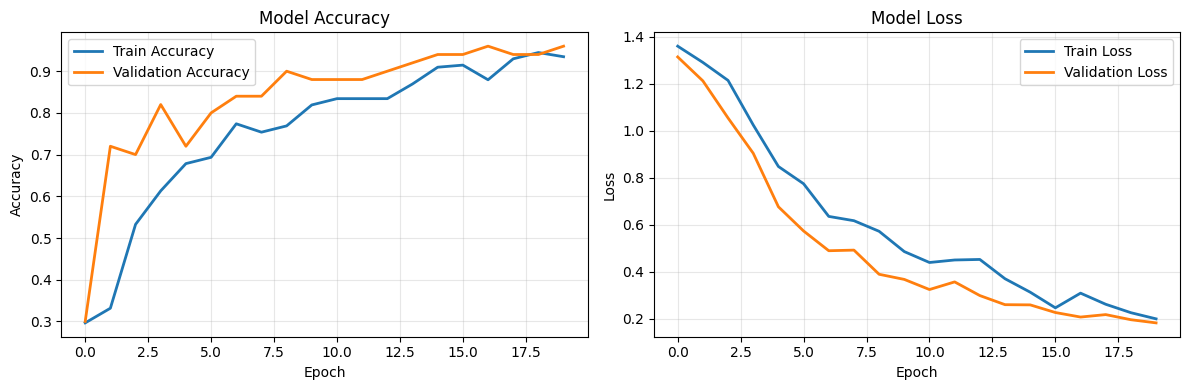

In [23]:
# ========== TRAINING VISUALIZATION ==========
# Create figure with 2 subplots for training metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Training and Validation Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Model Accuracy")
axes[0].legend()
axes[0].grid(True, alpha=0.3)  # Add subtle grid for better readability

# Plot 2: Training and Validation Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Model Loss")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [24]:
# ========== MODEL EVALUATION ==========
# Evaluate model performance on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

# Generate predictions for test set
y_pred = np.argmax(model.predict(X_test), axis=1)  # Get class index with highest probability
y_true = np.argmax(y_test, axis=1)  # Convert one-hot back to class indices

# Display confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9683 - loss: 0.1453
Test Accuracy: 0.9682539701461792
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
[[14  0  0  0]
 [ 0 15  0  0]
 [ 0  0 17  0]
 [ 0  1  1 15]]
              precision    recall  f1-score   support

    person_1       1.00      1.00      1.00        14
    person_2       0.94      1.00      0.97        15
    person_3       0.94      1.00      0.97        17
    person_4       1.00      0.88      0.94        17

    accuracy                           0.97        63
   macro avg       0.97      0.97      0.97        63
weighted avg       0.97      0.97      0.97        63



In [25]:
# ========== SAVE TRAINED MODEL ==========
# Save the complete trained model to disk for later use
model.save("palm_recognition_model.h5")
print("✓ Model saved successfully")

✓ Model saved successfully


In [26]:
# ========== CREATE EMBEDDING MODEL ==========
# Load the saved model fresh to ensure proper state
model_for_prediction = load_model("palm_recognition_model.h5")

# Create a new model that outputs embeddings (features from the second-to-last layer)
# This is useful for similarity comparisons and face/palm recognition systems
embedding_model = Model(
    inputs=model_for_prediction.inputs,           # Same input as original model
    outputs=model_for_prediction.layers[-2].output  # Output from Dense(128) layer
)

# ========== GENERATE REFERENCE EMBEDDINGS ==========
# Create a dictionary to store average embeddings for each person
reference_embeddings = {}
EMBEDDING_THRESHOLD = 1.2  # Threshold for similarity matching (not used here but defined for future)

# Generate embeddings for each person in the dataset
for person in class_names:
    embeddings = []
    person_path = os.path.join(DATASET_PATH, person)
    
    # Process all images for the current person
    for img_name in os.listdir(person_path):
        # Skip non-image files
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
            
        img_path = os.path.join(person_path, img_name)
        
        # Use same preprocessing as during training
        preprocessor = PalmPreprocessor()
        processed = preprocessor.preprocess_v2(img_path)
        
        if processed is None:
            continue
            
        # Reshape to match model input shape: (1, 128, 128, 1)
        if len(processed.shape) == 2:
            processed = processed.reshape(1, IMG_SIZE, IMG_SIZE, 1)
        else:
            processed = processed.reshape(1, IMG_SIZE, IMG_SIZE, 1)
        
        # Extract embedding (128-dimensional feature vector)
        emb = embedding_model.predict(processed, verbose=0)[0]
        embeddings.append(emb)
    
    # Store average embedding if valid images were found
    if embeddings:
        reference_embeddings[person] = np.mean(embeddings, axis=0)
        print(f"✓ Generated embeddings for {person}: {len(embeddings)} samples")
    else:
        print(f"✗ No valid images found for {person}")

# Save embeddings to disk for later use in recognition
with open("reference_embeddings.pkl", "wb") as f:
    pickle.dump(reference_embeddings, f)
print("✓ Embeddings saved successfully")

✓ Generated embeddings for person_1: 64 samples
✓ Generated embeddings for person_2: 80 samples
✓ Generated embeddings for person_3: 80 samples
✓ Generated embeddings for person_4: 88 samples
✓ Embeddings saved successfully


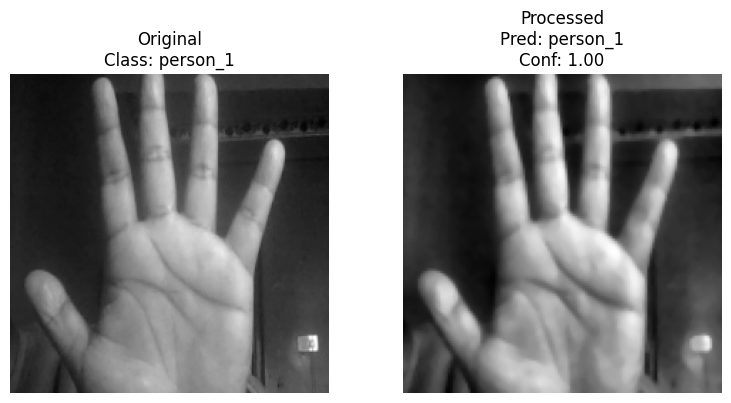


Prediction Results:
  Original class: person_1
  Predicted: person_1
  Confidence: 99.95%
  Correct: True

All class probabilities:
  person_1: 99.95%
  person_2: 0.00%
  person_3: 0.02%
  person_4: 0.03%


In [27]:
# ========== TEST PREDICTION WITH RANDOM SAMPLE ==========
# Threshold for classifying as "Unknown" (if confidence is too low)
CONFIDENCE_THRESHOLD = 0.6

# Randomly select a class for testing
true_label = random.choice(class_names)
class_path = os.path.join(DATASET_PATH, true_label)

# Get list of valid image files in the selected class
valid_images = [f for f in os.listdir(class_path) 
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

if not valid_images:
    print(f"No valid images found in {class_path}")
else:
    # Randomly select an image from the class
    img_name = random.choice(valid_images)
    img_path = os.path.join(class_path, img_name)
    
    # Preprocess the test image using the same pipeline
    preprocessor = PalmPreprocessor()
    processed = preprocessor.preprocess_v2(img_path)
    
    if processed is not None:
        # Reshape for model input
        if len(processed.shape) == 2:
            img_input = processed.reshape(1, IMG_SIZE, IMG_SIZE, 1)
        else:
            img_input = processed.reshape(1, IMG_SIZE, IMG_SIZE, 1)
        
        # Get prediction probabilities for all classes
        predictions = model_for_prediction.predict(img_input, verbose=0)[0]
        confidence = np.max(predictions)  # Highest probability
        predicted_index = np.argmax(predictions)  # Index of predicted class
        
        # Apply unknown detection logic
        if confidence < CONFIDENCE_THRESHOLD:
            predicted_label = "Unknown"  # Classify as unknown if confidence is low
        else:
            predicted_label = class_names[predicted_index]  # Otherwise use predicted class
        
        # Load original image for visualization
        img = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Create visualization with original and processed images
        plt.figure(figsize=(8, 4))
        
        # Plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(img_gray, cmap='gray')
        plt.title(f"Original\nClass: {true_label}")
        plt.axis('off')
        
        # Plot processed image with prediction results
        plt.subplot(1, 2, 2)
        plt.imshow(processed.squeeze(), cmap='gray')
        plt.title(f"Processed\nPred: {predicted_label}\nConf: {confidence:.2f}")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed prediction results
        print(f"\nPrediction Results:")
        print(f"  Original class: {true_label}")
        print(f"  Predicted: {predicted_label}")
        print(f"  Confidence: {confidence:.2%}")
        print(f"  Correct: {true_label == predicted_label}")
        
        # Display probabilities for all classes
        print("\nAll class probabilities:")
        for i, cls in enumerate(class_names):
            print(f"  {cls}: {predictions[i]:.2%}")
    else:
        print(f"Failed to preprocess image: {img_path}")